In [49]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import PowerTransformer

from imblearn.over_sampling import SMOTE

## models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## to make it possible to display multiple output inside one cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 50
pd.set_option('display.float_format', lambda x: '%9.8f' % x)

In [18]:
## load data, split Xy, upsample with SMOTE, split train/test
data = pd.read_csv('data/CarryAway_data_encoded.csv')

## define X and y 
X = data.drop('Y', axis=1).reset_index(drop=True)
y = data.Y

## Handle imbalance
smote = SMOTE()

orig_vc = y.value_counts()
print(f"Orig: {100* orig_vc[1]/(orig_vc.sum()):.2f}% Yes")

X_sm, y_sm = smote.fit_resample(X, y)
sm_vc = y_sm.value_counts()
print(f"After SMOTE: {100* sm_vc[1]/(sm_vc.sum()):.2f}% Yes")

## Data splitting train/test
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

Orig: 73.55% Yes
After SMOTE: 50.00% Yes


In [19]:
X_train.shape

(2816, 55)

## Testing RandomForestClassifier with Grid Search Cross-validation


## RandomForestClassifier Parameters

The main parameters to adjust when using these methods:
* n_estimators
* max_features (sqrt is best default for classification) 

Try starting with:
* max_depth=None
* min_samples_split=2 
* oob_score=True (with bootstrapping)

Also investigate parameters: 
1. max_leaf_nodes
1. min_samples_leaf

In [26]:
roc_auc_scorer = make_scorer(roc_auc_score, average='weighted')

In [55]:
cols_to_view = ['rank_test_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 
                'param_min_samples_leaf', 'param_n_estimators', 
                'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']

In [57]:
param_grid={'max_depth': [None, 5, 10, 15],
            'max_features': [5, 6, 7, 8, 9, 10],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 3, 4, 5],
            'n_estimators': [100, 150, 200]}

clf = RandomForestClassifier(oob_score=True, random_state=42)

grid_search1 = GridSearchCV(clf, param_grid, scoring=roc_auc_scorer, cv=5, return_train_score=True, n_jobs=4)
grid_search1.fit(X_train.values, y_train.values)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=4,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': [5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True,
             scoring=make_scorer(roc_auc_score, average=weighted))

In [58]:
cv_results1 = pd.DataFrame(grid_search1.cv_results_)
cv_results1.loc[:, cols_to_view].sort_values('rank_test_score').head(10)

,rank_test_score,param_max_depth,param_max_features,param_min_samples_split,param_min_samples_leaf,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
3,1,None,5,3,1,100,0.86284595,0.01444770,0.99681288,0.00051838
4,2,None,5,3,1,150,0.86211378,0.01691770,0.99690217,0.00027894
5,3,None,5,3,1,200,0.86032064,0.01591614,0.99716356,0.00072374
811,4,15,5,2,1,150,0.85994588,0.01701207,0.99742590,0.00065673
7,5,None,5,4,1,150,0.85929349,0.01962552,0.99354207,0.00106925
46,6,None,6,2,1,150,0.85890344,0.01939265,0.99777990,0.00056040
47,7,None,6,2,1,200,0.85889594,0.02008558,0.99777998,0.00056140
855,8,15,6,2,1,100,0.85853242,0.02538643,0.99716348,0.00077300
92,9,None,7,2,1,200,0.85815885,0.01827608,0.99777887,0.00056401
91,10,None,7,2,1,150,0.85815759,0.01836600,0.99777643,0.00056140


In [59]:
grid_search1.best_estimator_

RandomForestClassifier(max_features=5, min_samples_split=3, oob_score=True,
                       random_state=42)

In [60]:
best_model = grid_search1.best_estimator_
best_model.oob_score_

0.8544034090909091

In [62]:
cross_val_scores = cross_val_score(best_model, X_train, y_train, scoring=roc_auc_scorer, cv=5)
print(f"(weighted avg) AUC: {np.mean(cross_val_scores)} {np.std(cross_val_scores)}")

(weighted avg) AUC: 0.8628459515531326 0.014447699162059712


In [76]:
## fit best model on full train and test on test data
best_model = best_model.fit(X_train, y_train)

## use trained model to get predicted target var
# y_train_pred = best_model.predict(X_train)   
y_test_pred = best_model.predict(X_test) 

# print(f"(weighted avg) AUC: train {roc_auc_score(y_train, y_train_pred, average='weighted')}")
print(f"(weighted avg) AUC: TEST {roc_auc_score(y_test, y_test_pred, average='weighted')}")


(weighted avg) AUC: TEST 0.8566259903248993


# KNN

In [83]:
param_grid={'n_neighbors': [x for x in range(1,26)]}

clf = KNeighborsClassifier()

grid_search_knn = GridSearchCV(clf, param_grid, scoring=roc_auc_scorer, cv=5, return_train_score=True, n_jobs=4)
grid_search_knn.fit(X_train.values, y_train.values)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25]},
             return_train_score=True,
             scoring=make_scorer(roc_auc_score, average=weighted))

In [85]:
knn_cols_to_view = ['rank_test_score', 'param_n_neighbors', 
                    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']

cv_results_knn = pd.DataFrame(grid_search_knn.cv_results_)
cv_results_knn.loc[:, knn_cols_to_view].sort_values('rank_test_score').head(5)

,rank_test_score,param_n_neighbors,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1,1,0.81860470,0.01748781,0.99777753,0.00056228
2,2,3,0.78246739,0.01971363,0.89447165,0.00209138
4,3,5,0.73969042,0.01935169,0.84034624,0.00592418
1,4,2,0.73322530,0.01286145,0.85918558,0.00434844
6,5,7,0.71300646,0.02534676,0.80167506,0.00759782


In [86]:
best_model_knn = grid_search_knn.best_estimator_

## fit best model on full train and test on test data
best_model_knn = best_model_knn.fit(X_train, y_train)

## use trained model to get predicted target var
# y_train_pred = best_model.predict(X_train)   
y_test_pred = best_model_knn.predict(X_test) 

# print(f"(weighted avg) AUC: train {roc_auc_score(y_train, y_train_pred, average='weighted')}")
print(f"(weighted avg) AUC: TEST {roc_auc_score(y_test, y_test_pred, average='weighted')}")

(weighted avg) AUC: TEST 0.8305201779960104


# Logistic regression

In [78]:
## standardization
std_scaler=StandardScaler().fit(X_train) ## first fit the model on the training data

## now std scaler transform
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## apply regression
liblinear_model = LogisticRegression(solver='liblinear', random_state=42)
liblinear_model.fit(X_train_scaled, y_train)   # train model by fitting to training data

# use trained model to get predicted target var
y_test_pred = liblinear_model.predict(X_test_scaled) 

print(f"(weighted avg) AUC: TEST {roc_auc_score(y_test, y_test_pred, average='weighted')}")

## apply regression again, using a different solver
lbfgs_model = LogisticRegression(solver='lbfgs', random_state=42)
lbfgs_model.fit(X_train_scaled, y_train)   # train model by fitting to training data

# use trained model to get predicted target var
y_test_pred = lbfgs_model.predict(X_test_scaled) 

print(f"(weighted avg) AUC: TEST {roc_auc_score(y_test, y_test_pred, average='weighted')}")


LogisticRegression(random_state=42, solver='liblinear')

(weighted avg) AUC: TEST 0.7583688006267011


LogisticRegression(random_state=42)

(weighted avg) AUC: TEST 0.7583688006267011


# Attempting to look at the resulting decision tree nodes

In [71]:
featimp_df = pd.DataFrame({'feature_name': X.columns, 'importance': best_model.feature_importances_})
featimp_df.sort_values('importance', ascending=False).head(10)

,feature_name,importance
10,income,0.06925080
14,CoffeeHouse,0.06880796
8,age,0.06126441
7,time,0.06058211
15,CarryAway,0.05998837
9,education,0.05674419
12,minsToCouponDest,0.05484717
17,Restaurant20To50,0.05222112
16,RestaurantLessThan20,0.05132319
13,Bar,0.04915672


In [69]:
len(best_model.estimators_)
best_model.estimators_[0]

100

DecisionTreeClassifier(max_features=5, min_samples_split=3,
                       random_state=1608637542)

[Text(948.6000000000001, 951.3000000000001, 'X[26] <= 0.5\ngini = 0.5\nsamples = 1801\nvalue = [1441, 1375]'),
 Text(474.30000000000007, 679.5, 'X[29] <= 0.5\ngini = 0.492\nsamples = 1051\nvalue = [927, 719]'),
 Text(237.15000000000003, 407.70000000000005, 'X[24] <= 0.5\ngini = 0.486\nsamples = 887\nvalue = [804, 576]'),
 Text(118.57500000000002, 135.89999999999998, '\n  (...)  \n'),
 Text(355.725, 135.89999999999998, '\n  (...)  \n'),
 Text(711.45, 407.70000000000005, 'X[54] <= 0.5\ngini = 0.497\nsamples = 164\nvalue = [123, 143]'),
 Text(592.8750000000001, 135.89999999999998, '\n  (...)  \n'),
 Text(830.0250000000001, 135.89999999999998, '\n  (...)  \n'),
 Text(1422.9, 679.5, 'X[15] <= 3.0\ngini = 0.493\nsamples = 750\nvalue = [514, 656]'),
 Text(1185.7500000000002, 407.70000000000005, 'X[17] <= 1.991\ngini = 0.5\nsamples = 432\nvalue = [327, 341]'),
 Text(1067.1750000000002, 135.89999999999998, '\n  (...)  \n'),
 Text(1304.3250000000003, 135.89999999999998, '\n  (...)  \n'),
 Text(1

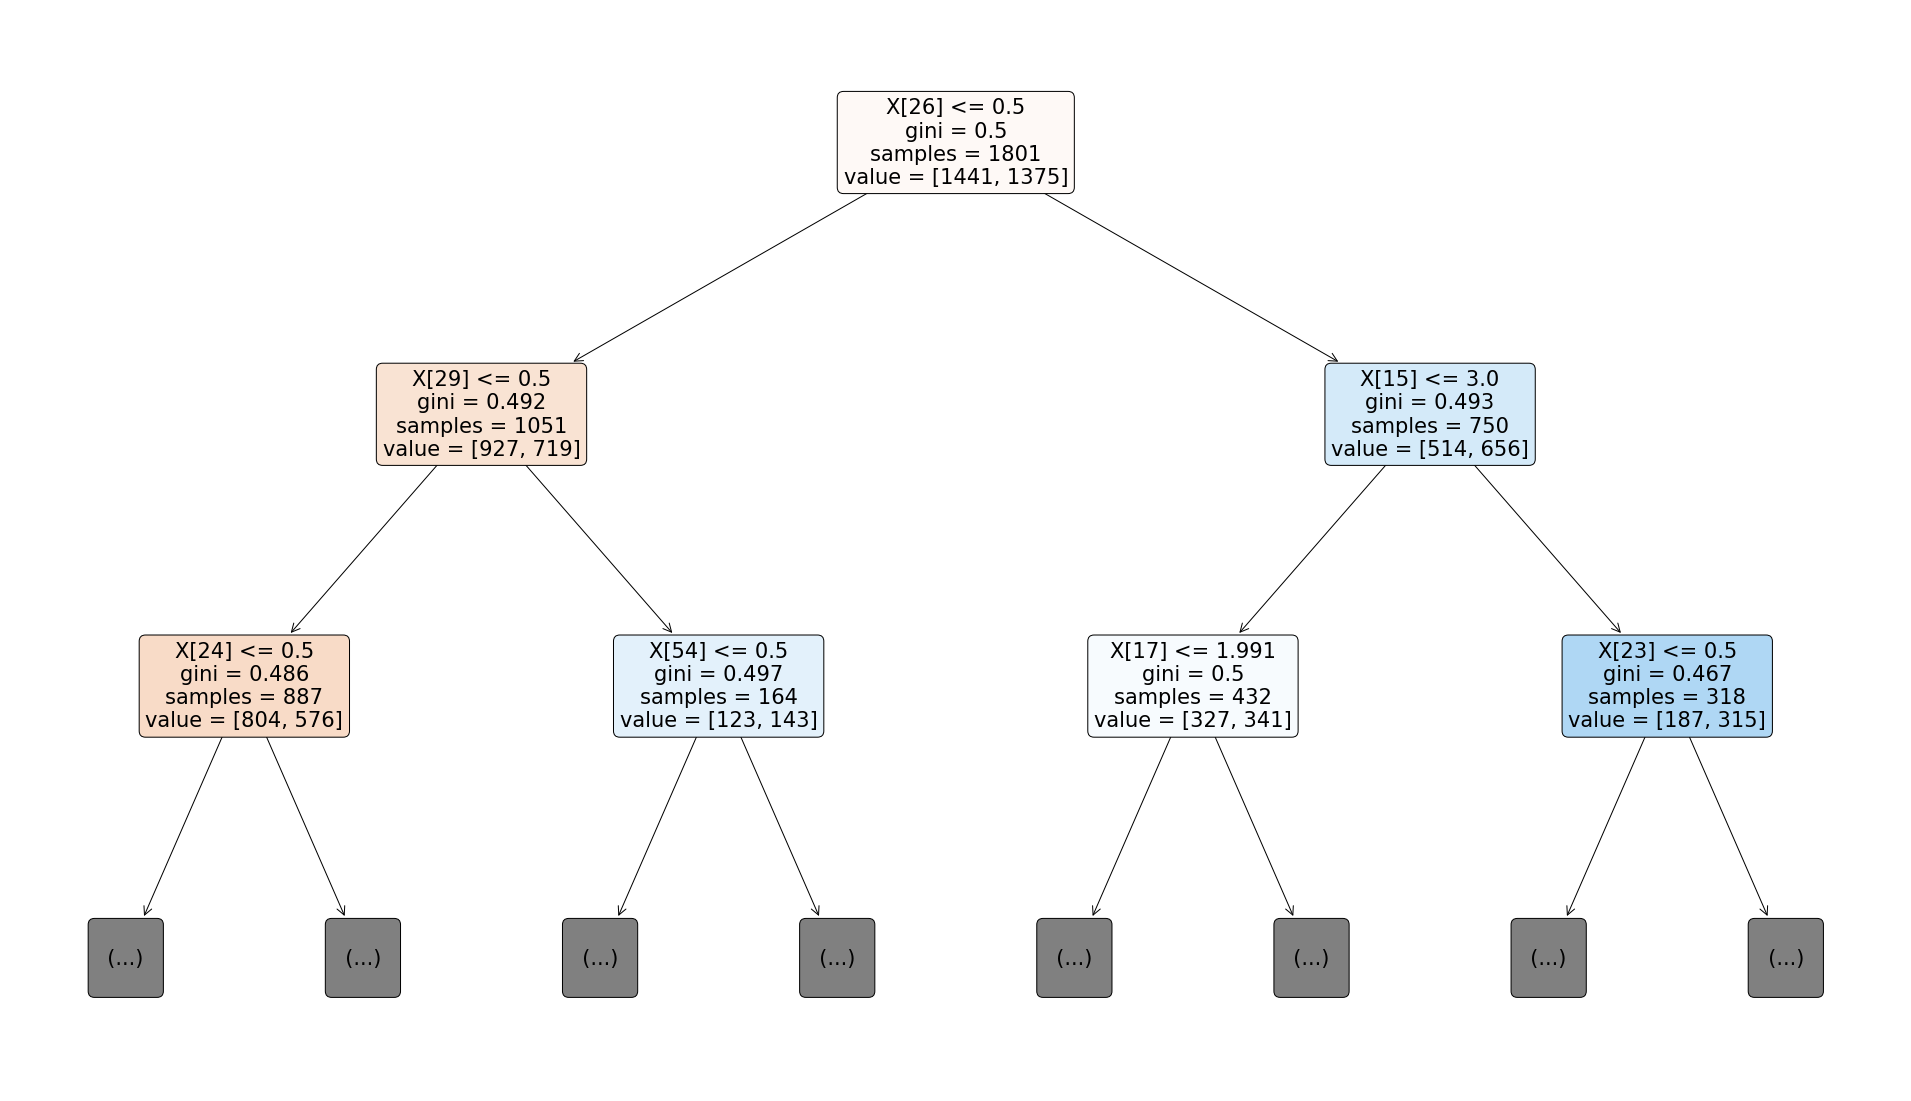

In [70]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(best_model.estimators_[0],filled = True, rounded=True, max_depth=2)# feature_names=X_train.columns)
plt.show() 

In [47]:
#Extracting the decision path for instance i = 12
i_data = X_train.iloc[12].values.reshape(1,-1)
d_path = best_model.decision_path(i_data)

print(d_path)

(<1x191152 sparse matrix of type '<class 'numpy.int64'>'
	with 1872 stored elements in Compressed Sparse Row format>, array([     0,   1287,   2500,   3803,   5138,   6411,   7594,   8885,
        10132,  11421,  12716,  13987,  15218,  16435,  17640,  18845,
        20102,  21453,  22676,  24041,  25378,  26627,  27918,  29083,
        30358,  31713,  33094,  34367,  35670,  36891,  38076,  39357,
        40670,  41915,  43256,  44489,  45714,  46983,  48184,  49455,
        50790,  51989,  53264,  54511,  55866,  57225,  58520,  59795,
        61070,  62311,  63594,  64823,  66084,  67347,  68598,  69923,
        71242,  72537,  73790,  74995,  76316,  77647,  78926,  80169,
        81472,  82843,  84114,  85369,  86632,  87959,  89258,  90561,
        91860,  93185,  94418,  95703,  97002,  98273,  99514, 100773,
       102060, 103317, 104512, 105835, 107146, 108367, 109644, 110891,
       112094, 113415, 114630, 115881, 117204, 118509, 119732, 120981,
       122286, 123481, 124674,